In [167]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [417]:
train = pd.read_csv('train.csv')

test = pd.read_csv('test.csv')

In [418]:
def drop_feature(data):
    data = data.drop('Id' , axis = 1)
    data = data.drop('Alley' , axis=1)
    data = data.drop('Street' , axis = 1)
    data = data.drop('Utilities' , axis=1)
    data = data.drop('Condition2' , axis=1)
    data = data.drop('RoofMatl' , axis=1)
    data = data.drop('LowQualFinSF' , axis = 1)
    data = data.drop('3SsnPorch' , axis = 1)
    data = data.drop('PoolArea' , axis = 1)
    data = data.drop('PoolQC' , axis = 1)
    
    return data

train = drop_feature(train)

test = drop_feature(test)

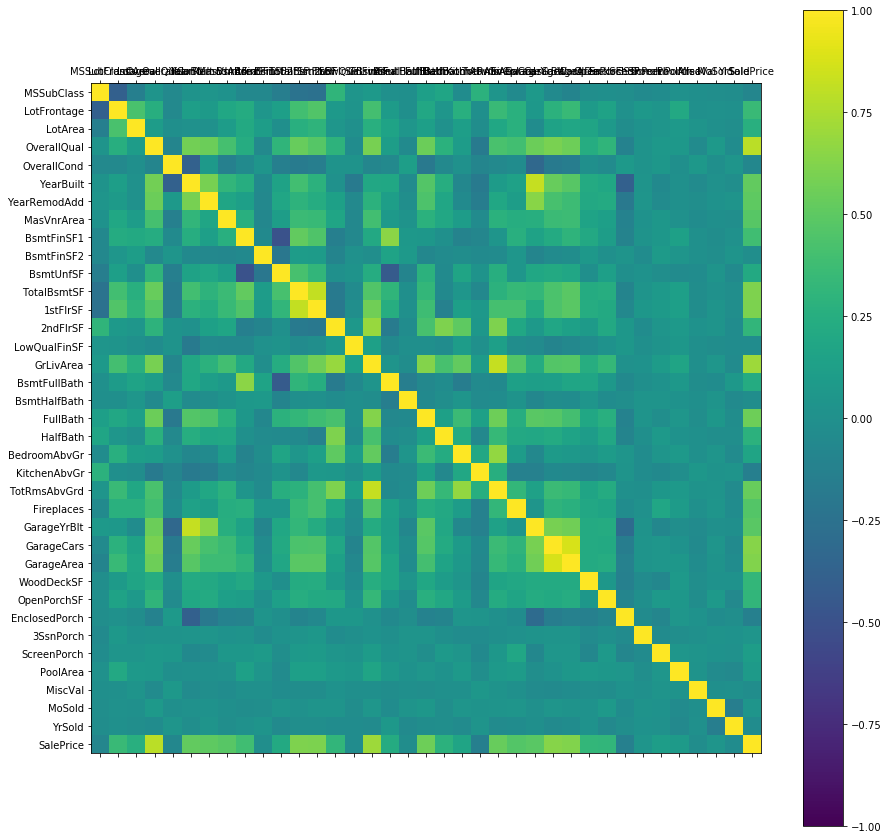

In [19]:
#不必执行
corr_matrix = train.corr()
#相关矩阵 数字型特征的
fig = plt.figure(figsize=(15 , 15))
ax = fig.add_subplot(111)
#根据矩阵画图
cax = ax.matshow(corr_matrix , vmin=-1 , vmax=1 )

fig.colorbar(cax)
ticks = np.arange(0 , 37 , 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels([label for label in train.columns if train[label].dtype != np.object])
ax.set_yticklabels([label for label in train.columns if train[label].dtype != np.object])

plt.savefig('test.png')
plt.show()
plt.close()

In [45]:
#暂时不用执行
train.MSSubClass = np.log(train['MSSubClass'])
train.MSZoning = np.log(train.MSZoning)
train.loc[train['LotFrontage']>150 , 'LotFrontage'] = 150 #将大于150的值进行截断

In [419]:
object_columns = []
num_columns = []
columns = train.columns

for column in columns:
    if train[column].dtype == np.object:
        object_columns.append(column)
    else:
        num_columns.append(column)

In [420]:
less_value = []
more_value = [] #暂时不用
for object_column in object_columns:
    if train[object_column].value_counts().size <= 10:
        less_value.append(object_column)
    else:
        more_value.append(object_column)

In [421]:
no_miss_less = []
yes_miss_less = []

for less_v in less_value:
    if np.sum(train[less_v].isnull()) > 0:
        yes_miss_less.append(less_v)
    else:
        no_miss_less.append(less_v)

In [422]:
for i in no_miss_less:
    
    a = list(train[i].value_counts().index) #考虑排序
    b = list(range(len(train[i].value_counts().index)))
    b = [item + 1 for item in b]
    
    map_dict = dict(zip(a , b))
    train[i] = train[i].map(map_dict)
    
    test[i] = test[i].map(map_dict)

In [ ]:
#将和saleprice相关性弱的特征去掉

In [298]:
for i in yes_miss_less:
    print('%s[%d] ' % (i , np.sum(train[i].isnull())))
    print(train[i].value_counts()[0])
    #print(train[i].value_counts())
    #print('\n')


MasVnrType[8] 
864
BsmtQual[37] 
649
BsmtCond[37] 
1311
BsmtExposure[38] 
953
BsmtFinType1[37] 
430
BsmtFinType2[38] 
1256
Electrical[1] 
1334
FireplaceQu[690] 
380
GarageType[81] 
870
GarageFinish[81] 
605
GarageQual[81] 
1311
GarageCond[81] 
1326
Fence[1179] 
157
MiscFeature[1406] 
49


In [423]:
drop_feature = ['Fence' , 'MiscFeature' , 'BsmtCond' , 'BsmtFinType2' , 'Electrical' , 'GarageQual' , 'GarageCond']
train = train.drop(drop_feature , axis = 1)

test = test.drop(drop_feature , axis = 1)

In [424]:
true_yes_miss_less = list(set(yes_miss_less) - set(drop_feature))

In [425]:
true_yes_miss_less

['GarageFinish',
 'MasVnrType',
 'GarageType',
 'BsmtQual',
 'BsmtFinType1',
 'FireplaceQu',
 'BsmtExposure']

In [426]:
#对缺失进行填充
for i in true_yes_miss_less:
    a = list(train[i].value_counts().index) #考虑排序
    b = list(range(len(train[i].value_counts().index)))
    b = [item + 1 for item in b]
    
    map_dict = dict(zip(a , b))
    train[i] = train[i].map(map_dict)
    test[i] = test[i].map(map_dict)
    
    train[i] = train[i].fillna(train[i].max())
    test[i] = test[i].fillna(test[i].max())

#使用平均中进行填充
#=======
#==========

In [427]:
train.shape

(1460, 64)

In [428]:
ok_object_columns = list(set(no_miss_less) | set(true_yes_miss_less))
final_object_columns = []

for column in ok_object_columns:
    if np.abs(train[column].corr(train.SalePrice)) > 0.3 :
        final_object_columns.append(column)

In [429]:
#这是最终的object类型的feature
final_object_columns

['GarageFinish',
 'KitchenQual',
 'Foundation',
 'BsmtQual',
 'FireplaceQu',
 'MasVnrType',
 'HeatingQC',
 'ExterQual']

In [430]:
num_columns.remove('SalePrice')
#这些是数字型feature

In [431]:
#修复数字型feature的缺失值
for i in num_columns:
    _ = np.sum(train[i].isnull())
    if _ != 0:
        train[i] = train[i].fillna(train[i].mean())
        test[i] = test[i].fillna(test[i].mean())

In [432]:
final_num_columns = []

for i in num_columns:
    if np.abs(train[i].corr(train.SalePrice)) > 0.3:
        final_num_columns.append(i)

In [433]:
#进行缩放的数字型feature

divide_1000 = ['YearBuilt','YearRemodAdd','BsmtFinSF1','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageYrBlt']
divide_100 = ['MasVnrArea','GarageArea','WoodDeckSF','OpenPorchSF']

for i in divide_1000:
    train[i] = train[i]/1000
    test[i] = test[i]/1000

for i in divide_100:
    train[i] = train[i]/100
    test[i] = test[i]/100


In [434]:
train.LotFrontage = train.LotFrontage/100
test.LotFrontage = test.LotFrontage/100

In [435]:
train_data_feature = list(set(final_object_columns)|set(final_num_columns))
train_data = train[train_data_feature]

test_data = test[train_data_feature]

In [436]:
train.SalePrice = train['SalePrice'] / 100000

In [437]:
train_label = train['SalePrice']

In [382]:
#现在开始使用模型进行训练
from sklearn.ensemble import RandomForestRegressor

In [438]:
forest = RandomForestRegressor(n_estimators = 100)
forest.fit(train_data , train_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [439]:
forest.score(train_data , train_label)

0.980194025903059

In [385]:
from sklearn.cross_validation import KFold

In [407]:
def rmse(y_hat , y):
    return np.sqrt(np.average(np.square(y_hat - y)))

kf = KFold(train_data.shape[0] , 10 , shuffle=True)
for train_index , vali_index in kf:
    forest.fit(train_data.iloc[train_index] , train_label.iloc[train_index])
    #print(forest.score(train_data.iloc[vali_index] , train_label.loc[vali_index]))
    y_hat = forest.predict(train_data.iloc[vali_index])
    print(rmse(y_hat , train_label.loc[vali_index]))

0.3797716189496384
0.26025242167517115
0.38233633967870967
0.35458263652424604
0.30594940878936266
0.2382659462640906
0.23483452726523085
0.2450263058206035
0.31303777245812403
0.24305852629308572


In [450]:
test_prediction = forest.predict(test_data)
test_prediction = test_prediction*100000

#1461
result = pd.DataFrame({'Id':[x for x in range(len(test_prediction))] , 'SalePrice':test_prediction})
result.to_csv('submit.csv')

In [444]:
test_data.to_csv('gg.csv')

In [445]:
test_columns = test_data.columns

for i in test_columns:
    if np.sum(test_data[i].isnull()) > 0:
        miss_test.append(i)

GarageCars
BsmtFinSF1
KitchenQual
GarageArea
TotalBsmtSF


In [446]:
test_data['GarageCars'] = test_data['GarageCars'].fillna(test_data['GarageCars'].mean())
test_data['BsmtFinSF1'] = test_data['BsmtFinSF1'].fillna(test_data['BsmtFinSF1'].mean())
test_data['KitchenQual'] = test_data['KitchenQual'].fillna(test_data['KitchenQual'].mean())
test_data['GarageArea'] = test_data['GarageArea'].fillna(test_data['GarageArea'].mean())
test_data['TotalBsmtSF'] = test_data['TotalBsmtSF'].fillna(test_data['TotalBsmtSF'].mean())

I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi